# Figure4: Mouse Placentation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import random
import warnings

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv

from steer import us_transition_matrix, velocity_graph

warnings.filterwarnings('ignore')

# ============================================================================
# 1. Configuration & Global Settings
# ============================================================================
BASE_DIR = '/nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures'
DATA_PATH = os.path.join(BASE_DIR, 'Data4NoteBook', 'Figure4_MousePlacentation.adata')
RESULT_PATH = os.path.join(BASE_DIR, 'Results_Figure4')

os.makedirs(RESULT_PATH, exist_ok=True)

# Set Reproducibility Seeds
SEED = 618
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Plotting Settings (Publication Ready)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

scv.settings.figdir = RESULT_PATH
scv.settings.plot_prefix = ""
scv.set_figure_params(style='scvelo', dpi=300, fontsize=7, figsize=(5, 4), frameon=True, transparent=True, format='png')

sc.settings.figdir = RESULT_PATH
sc.settings.plot_prefix = ""
sc.settings.set_figure_params(dpi=300, fontsize=7, color_map='magma', frameon=True, vector_friendly=True, transparent=True)

sns.set_theme(context='paper', style='white', font_scale=1, 
              rc={"figure.dpi": 300, "axes.titlesize": 7, "axes.labelsize": 7, "legend.fontsize": 6, "grid.linewidth": 0.5})

# ============================================================================
# 2. Data Loading
# ============================================================================
print(f"Loading Mouse Placentation data from: {DATA_PATH}")
result_adata = sc.read_h5ad(DATA_PATH)
print("Data loaded successfully!")

STEER package is imported
Loading Mouse Placentation data from: /nvme/users/liuzhy/Review_Files/NoteBook_Main_Figures/Data4NoteBook/Figure4_MousePlacentation.adata
Data loaded successfully!


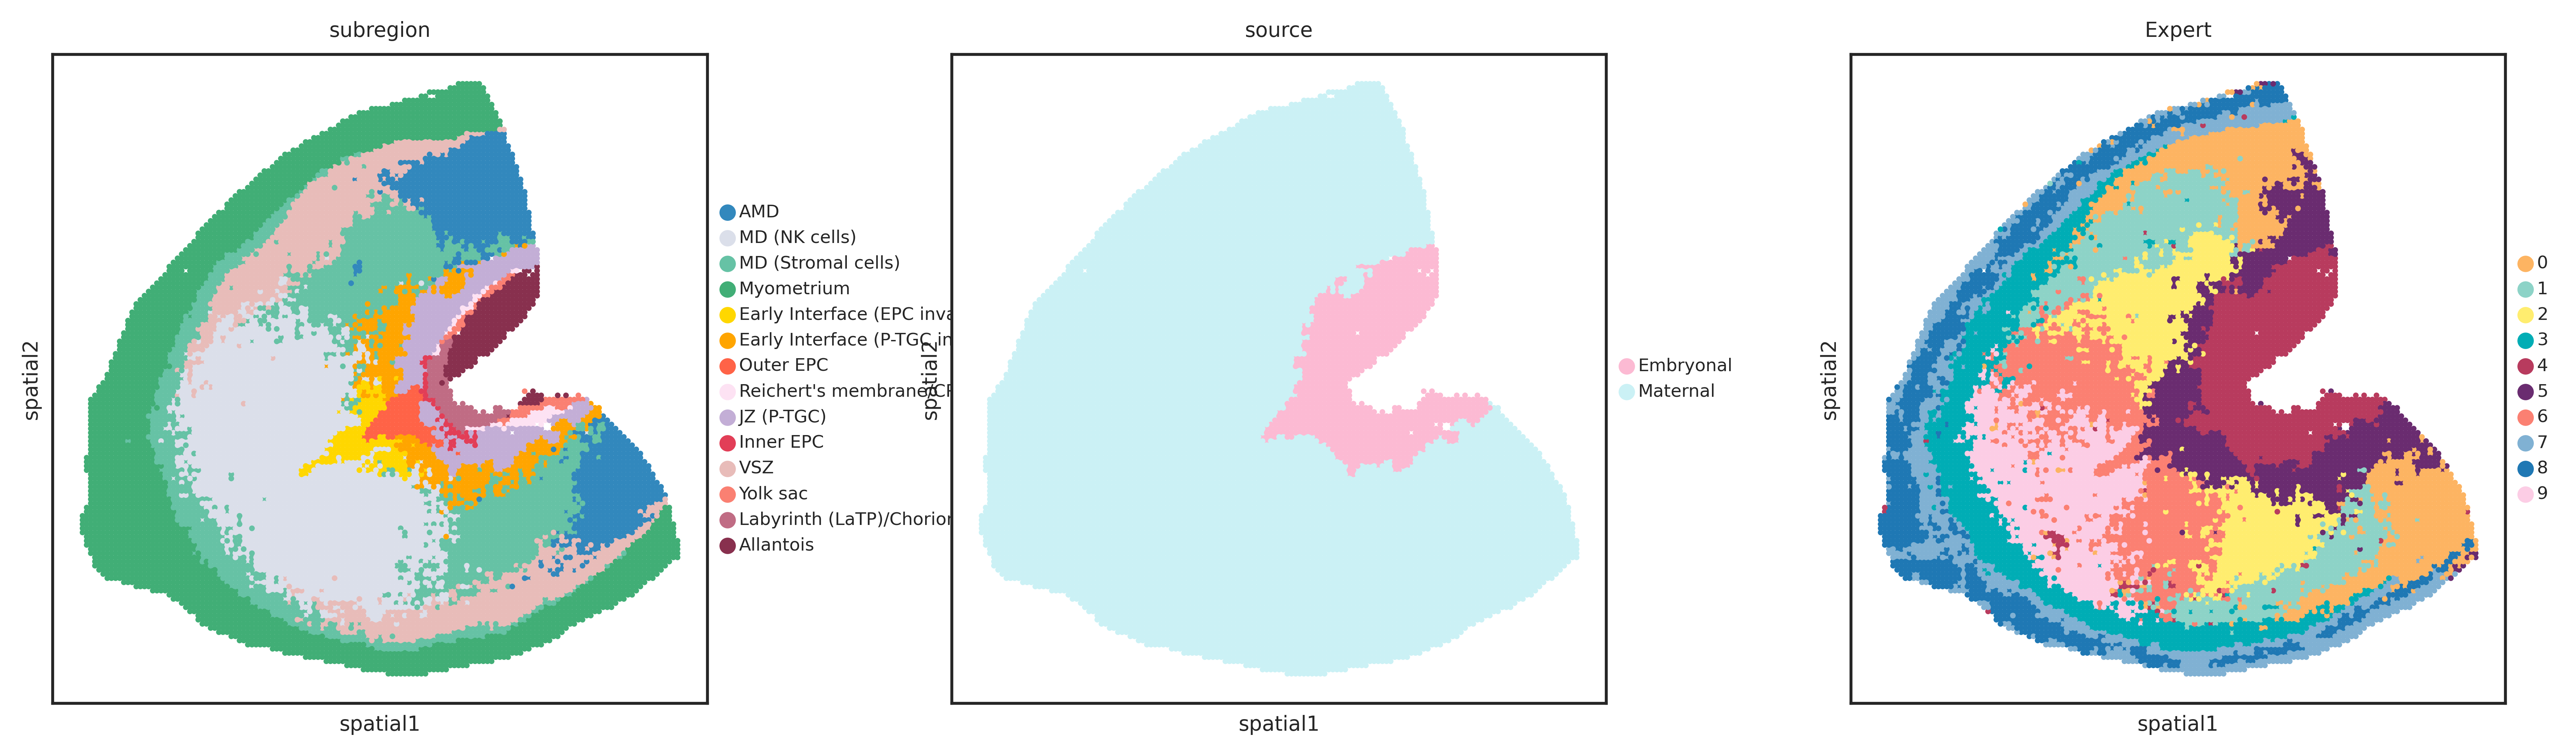

In [2]:
# ============================================================================
# 1. Expert Colors
# ============================================================================
result_adata.uns['Expert_colors'] = ['#FDB462', '#8DD3C7','#FFED6F','#00ADB5', '#B83B5E', '#6A2C70', '#FB8072','#80B1D3','#1F78B4','#FCCDE5']

# ============================================================================
# 2. Maternal vs Embryonal Source Mapping
# ============================================================================
maternal_labels = ['Decidua', 'Myometrium']
embryonal_labels = ['Ectoplacental cone', 'Allantois', 'Chorion', 'P-TGC', 'Yolk sac']
ordered_celltypes = maternal_labels + embryonal_labels

celltype_colors = {
    'Allantois': '#FFE2E2', 'Chorion': '#FDDBBB', 'Decidua': '#CBF1F5', 
    'Ectoplacental cone': '#F67280', 'Myometrium': '#71C9CE', 'P-TGC': '#FCBAD3', 'Yolk sac': '#FFFFD2'
}

result_adata.obs['celltype'] = pd.Categorical(result_adata.obs['celltype1'], categories=ordered_celltypes, ordered=True)
result_adata.uns['celltype_colors'] = [celltype_colors[cell] for cell in ordered_celltypes]

source_mapping = {cell: 'Maternal' for cell in maternal_labels}
source_mapping.update({cell: 'Embryonal' for cell in embryonal_labels})
result_adata.obs['source'] = result_adata.obs['celltype'].map(source_mapping)
result_adata.uns['source_colors'] = ['#FCBAD3', '#CBF1F5']

# ============================================================================
# 3. Subregion Annotations
# ============================================================================
grouped_order = [
    "AMD", "MD (NK cells)", "MD (Stromal cells)", "Myometrium",          # Maternal
    "Early Interface (EPC inva.)", "Early Interface (P-TGC inva.)",      # Interface
    "Outer EPC", "Reichert's membrane/CP", "JZ (P-TGC)", "Inner EPC",    # Embryonal
    "VSZ", "Yolk sac", "Labyrinth (LaTP)/Chorion", "Allantois"
]
result_adata.obs["subregion"] = pd.Categorical(result_adata.obs["subregion"], categories=grouped_order, ordered=True)
result_adata.uns['subregion_colors'] = [
    "#3288BD", "#DBDFEA", "#66C2A5", "#41AE76",  # Maternal
    "#FFD700", "#FFA500",                        # Interface
    "#FF6347", "#FDE2F3", "#C3AED6", "#E23E57",  
    "#E8BCB9", "#FA8072", "#C06C84", "#88304E"   # Embryonal
]

if 'Expert Weight' in result_adata.obs:
    result_adata.obs['Dynamic Certainty'] = result_adata.obs['Expert Weight']

# Plot Source & Label Mapping
sc.pl.embedding(
    result_adata, basis='spatial', color=['subregion', 'source', 'Expert'],
    size=15, frameon=True, wspace=0.25, show=False
)
source_label_path = os.path.join(RESULT_PATH, 'source_label_show.pdf')
plt.savefig(source_label_path, dpi=300, bbox_inches='tight')
plt.show()

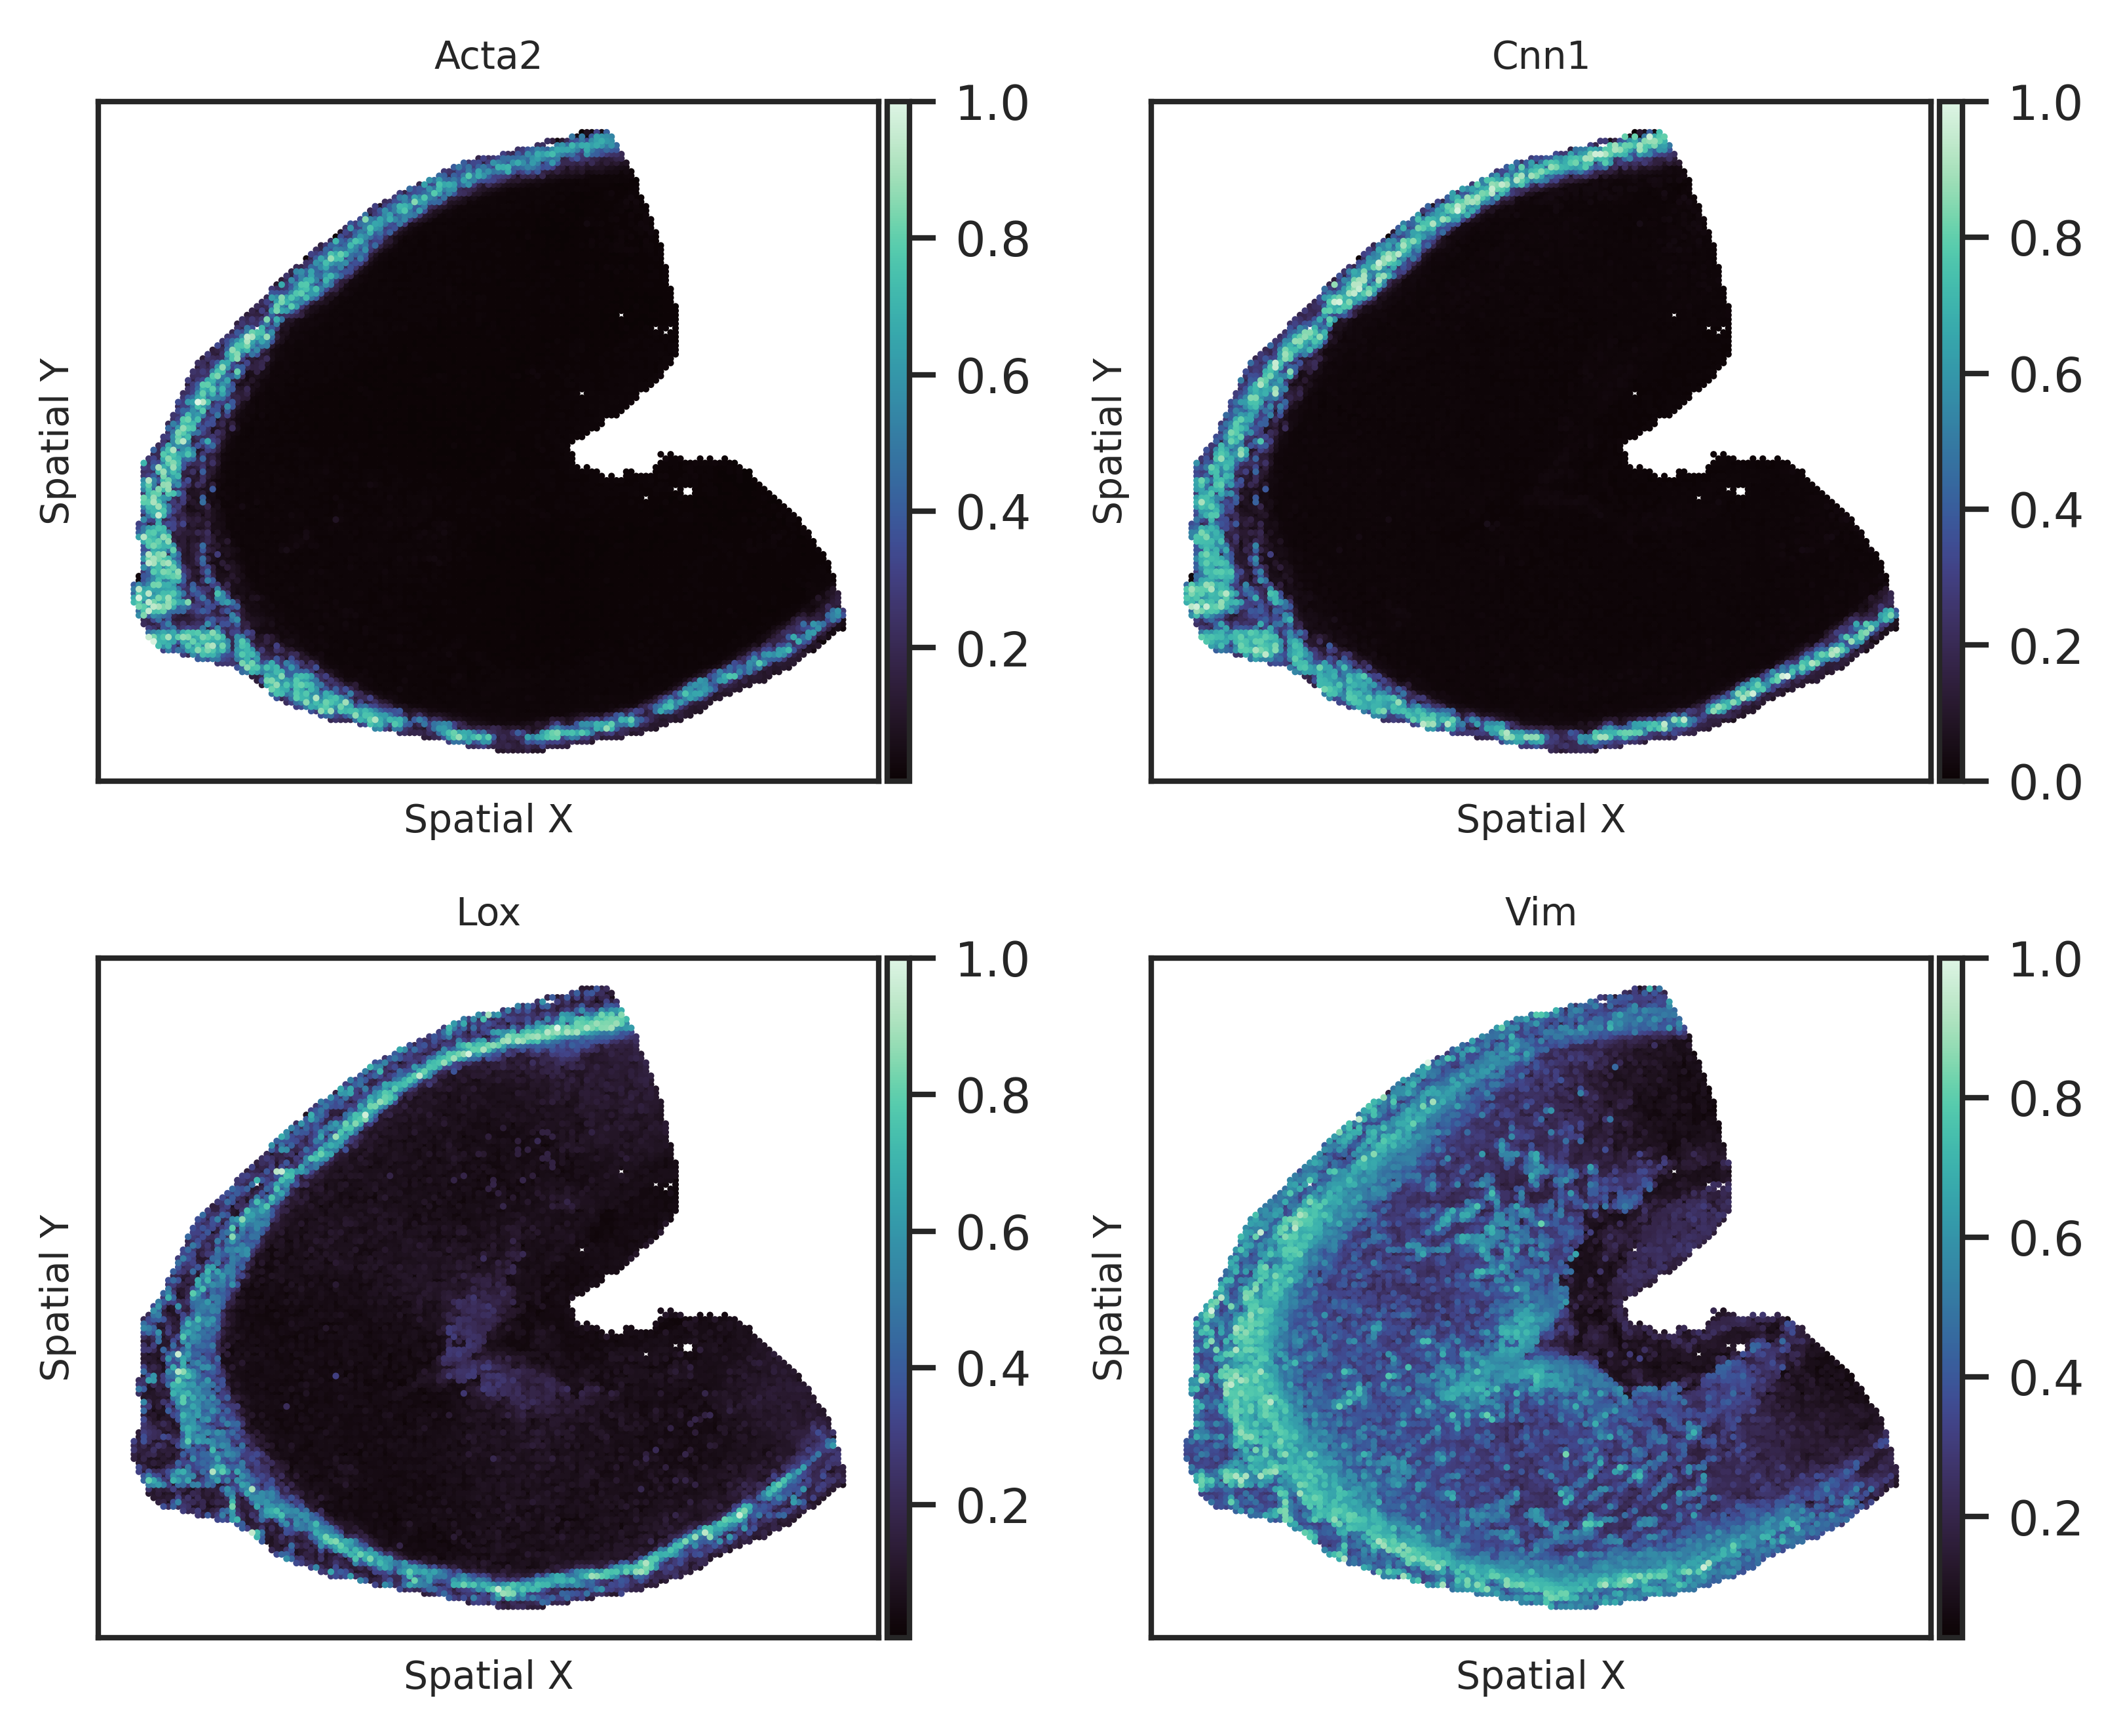

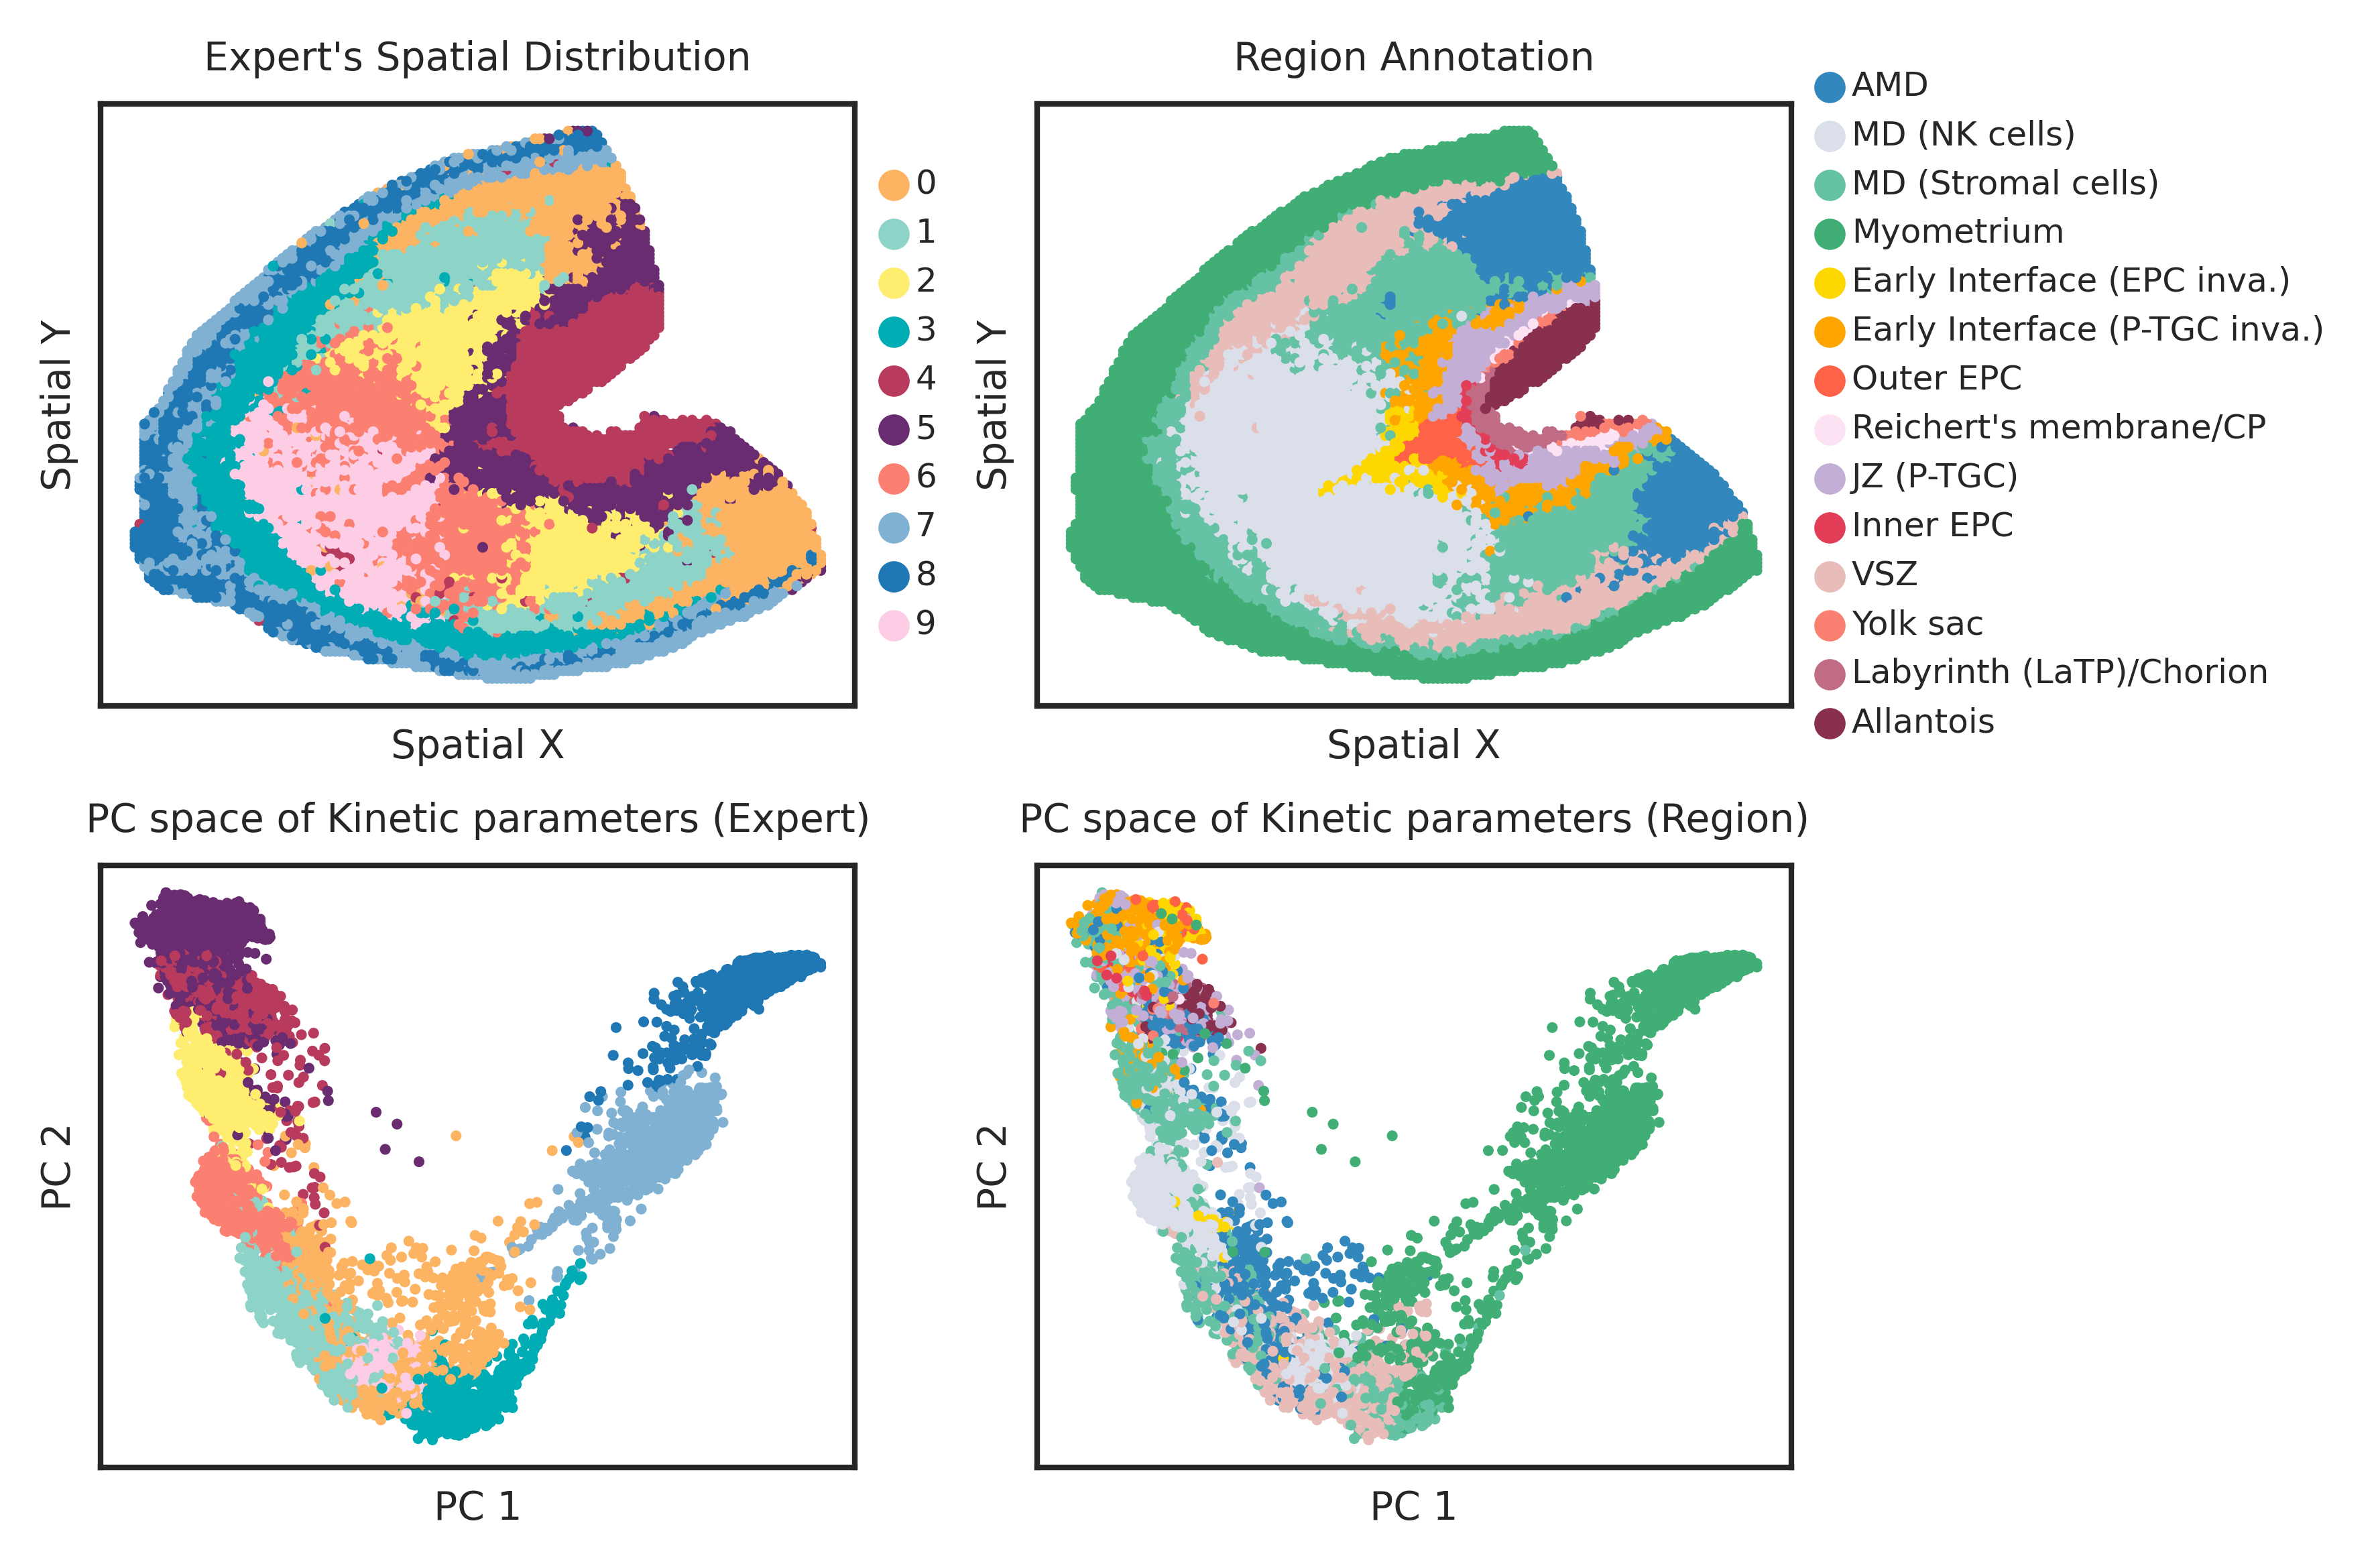

In [3]:
# ============================================================================
# 1. Spatial Gene Expression Grid
# ============================================================================
genes = ['Acta2', 'Cnn1', 'Lox', 'Vim']
fig, axes = plt.subplots(2, 2, figsize=(5.5, 4.5)) 

for i, gene in enumerate(genes):
    ax = axes[i // 2, i % 2]
    sc.pl.embedding(result_adata, basis='spatial', color=gene, layer='model_Ms', color_map='mako', size=6, show=False, ax=ax)
    ax.set_xlabel('Spatial X')
    ax.set_ylabel('Spatial Y')

plt.tight_layout()
gene_expr_path = os.path.join(RESULT_PATH, 'Supp_Myo_MD.pdf')
plt.savefig(gene_expr_path, dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 2. Spatial vs PCA Parameter Space Grid
# ============================================================================
titles = [
    ["Expert's Spatial Distribution", "Region Annotation"],
    ["PC space of Kinetic parameters (Expert)", "PC space of Kinetic parameters (Region)"]
]
xlabels = [["Spatial X", "Spatial X"], ["PC 1", "PC 1"]]
ylabels = [["Spatial Y", "Spatial Y"], ["PC 2", "PC 2"]]

bases = ['spatial', 'X_pca_para_t']
labels = ['Expert', 'subregion']

fig, axes = plt.subplots(2, 2, figsize=(6, 4))

for row, basis in enumerate(bases):
    for col, label in enumerate(labels):
        ax = axes[row, col]
        legend_loc = 'right margin' if row == 0 else None

        sc.pl.embedding(result_adata, basis=basis, color=label, size=15, color_map='magma_r', frameon=True, show=False, ax=ax, legend_loc=legend_loc)
        
        ax.set_title(titles[row][col], fontsize=7)
        ax.set_xlabel(xlabels[row][col], fontsize=7)
        ax.set_ylabel(ylabels[row][col], fontsize=7)

plt.tight_layout(w_pad=0.5, h_pad=0.5)
pca_space_path = os.path.join(RESULT_PATH, 'spatial_pca_show.pdf')
plt.savefig(pca_space_path, dpi=300, bbox_inches='tight')
plt.show()

Computing US Transition Matrix for Placentation...
Computing Velocity Graph on Spatial Coordinates...
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/128 cores)
    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Renamed 'spatial' to convention 'X_spatial' (adata.obsm).
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


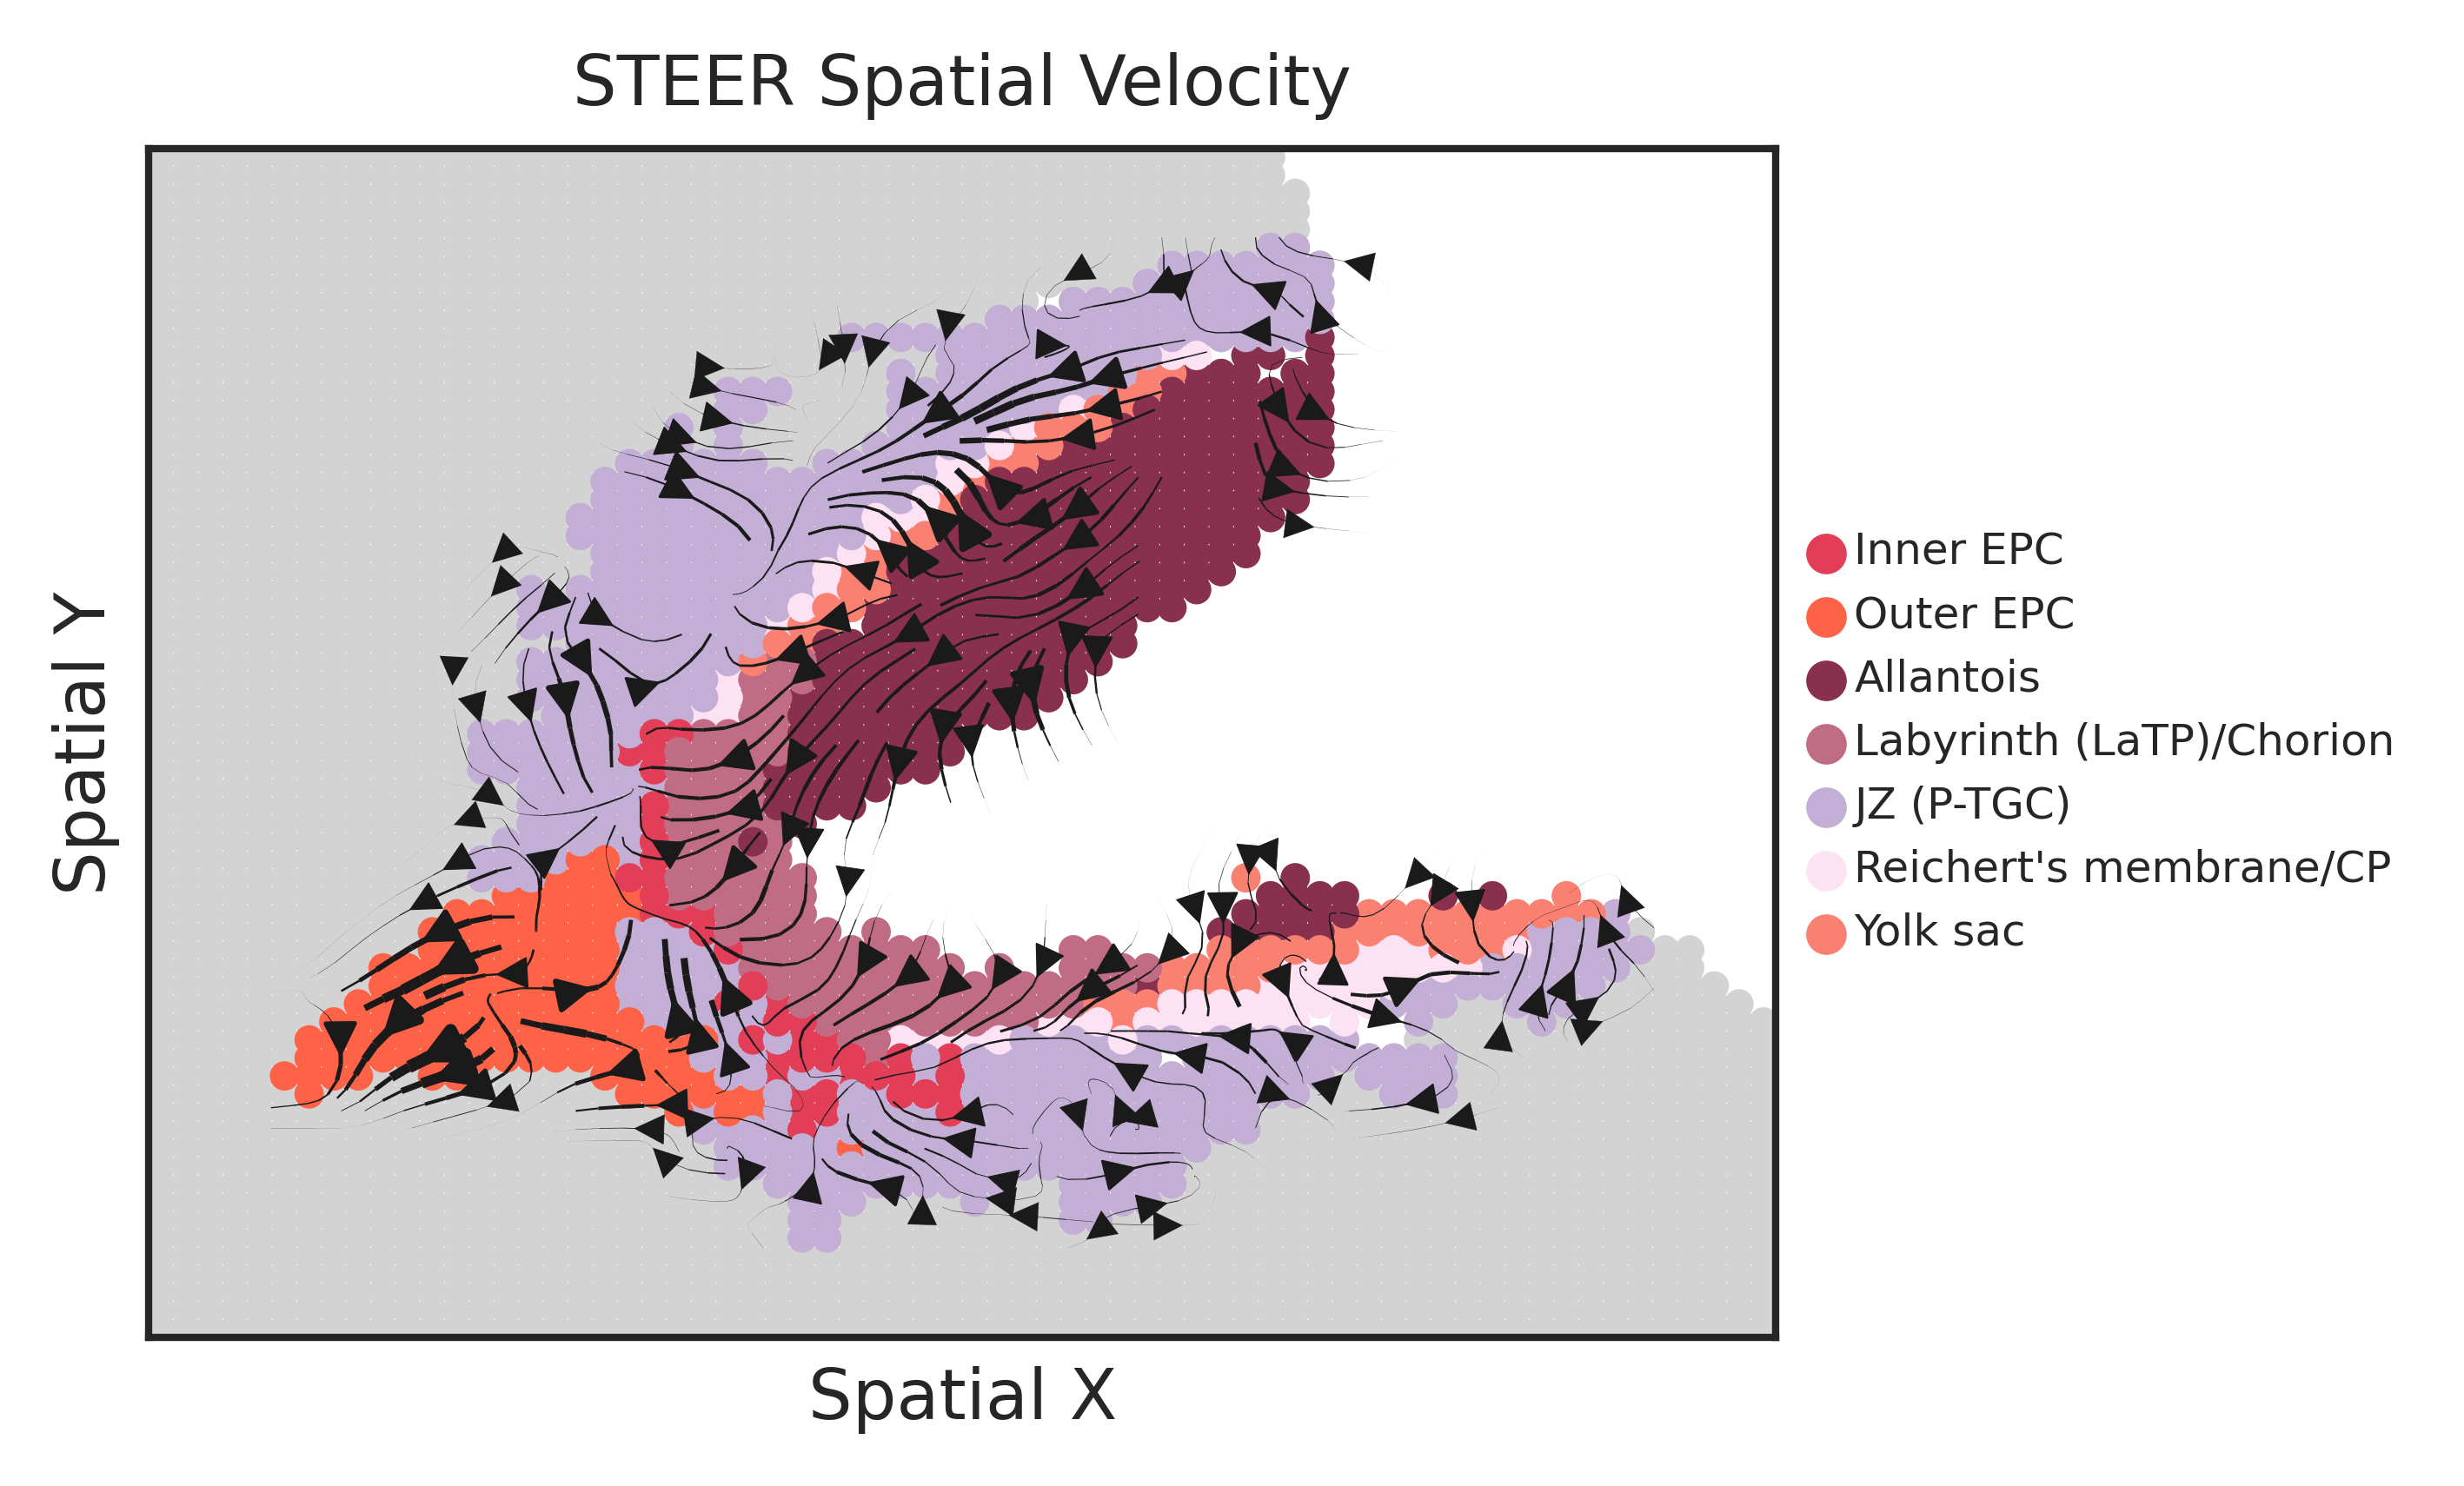

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap_refine_embed', embedded velocity vectors (adata.obsm)


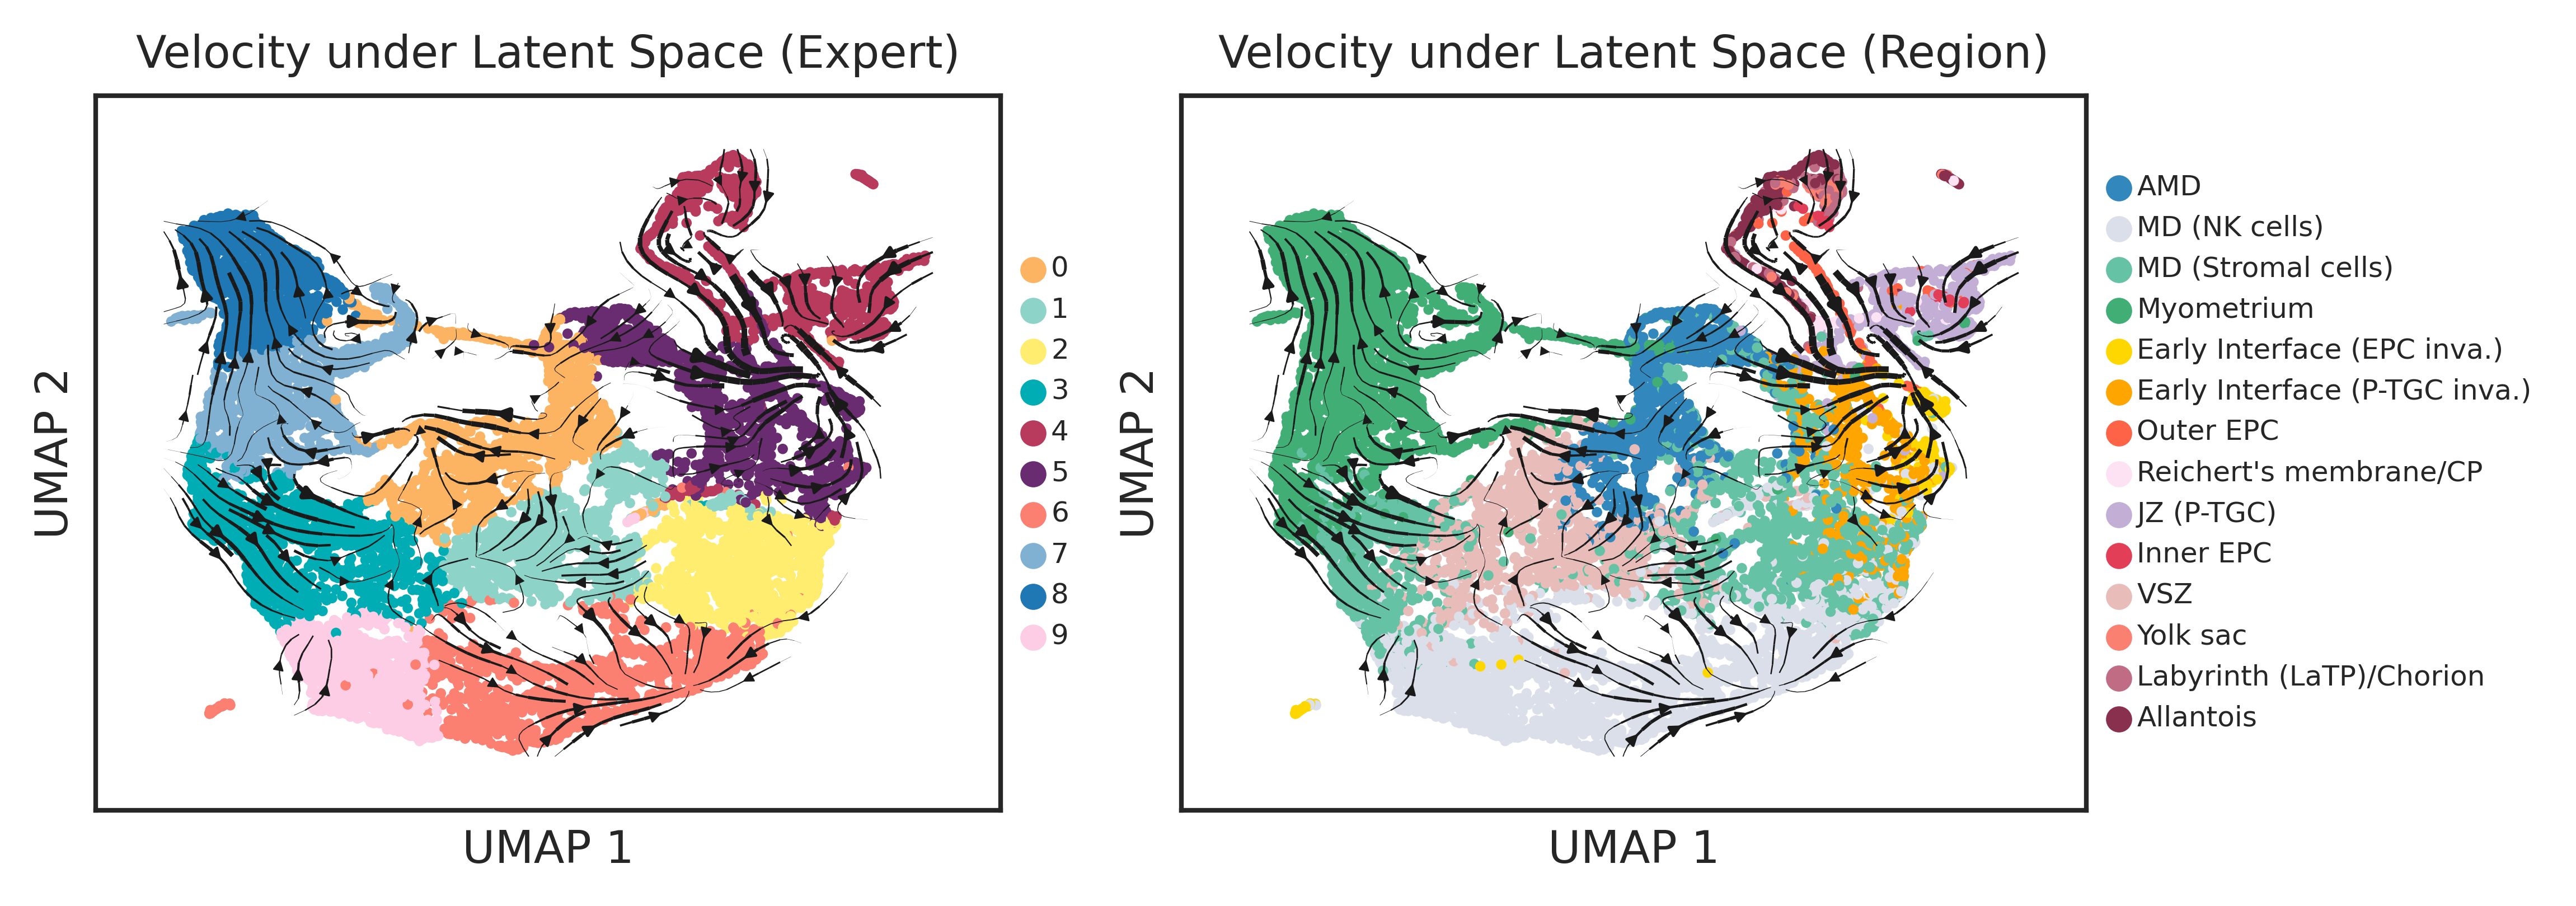

✅ Figure 4 (Mouse Placentation) rendering complete!


In [4]:
# ============================================================================
# 1. Compute US Transition Matrix
# ============================================================================
print("Computing US Transition Matrix for Placentation...")
combined_adata = us_transition_matrix(
    result_adata, 
    velocity_u_key='pred_vu', 
    velocity_s_key='pred_vs', 
    unspliced_key='model_Mu', 
    spliced_key='model_Ms'
)

# Inherit pre-configured colors & types
combined_adata.uns['Expert_colors'] = result_adata.uns['Expert_colors']
combined_adata.obs["subregion"] = result_adata.obs["subregion"]
combined_adata.uns['subregion_colors'] = result_adata.uns['subregion_colors']
combined_adata.obsm["spatial"] = combined_adata.obsm["spatial"].astype(float)

print("Computing Velocity Graph on Spatial Coordinates...")
sc.pp.neighbors(combined_adata, use_rep='X_refine_embed', n_neighbors=30)
velocity_graph(combined_adata, vkey='velocity', xkey='used_Mu_Ms', basis='spatial', show_progress_bar=False)

# ============================================================================
# 2. Plot Spatial Velocity Stream (Embryonal Subsets)
# ============================================================================
embryonal_subset = [
    'Inner EPC', 'Outer EPC', 'Allantois', 'Labyrinth (LaTP)/Chorion', 
    'JZ (P-TGC)', "Reichert's membrane/CP", 'Yolk sac'
]

scv.pl.velocity_embedding_stream(
    combined_adata, color='subregion', size=66, smooth=0.8, alpha=1, 
    groups=embryonal_subset, legend_loc='right', basis='spatial', 
    add_margin=0.1, xlabel='Spatial X', ylabel='Spatial Y', 
    figsize=(4, 3), frameon=True, dpi=300, title='STEER Spatial Velocity', show=False
)

spatial_velo_path = os.path.join(RESULT_PATH, 'GATEVelo_whole_part.pdf')
plt.savefig(spatial_velo_path, bbox_inches='tight')
plt.show()

# ============================================================================
# 3. Plot Velocity Stream in Latent Space (UMAP Refine Embed)
# ============================================================================

scv.pl.velocity_embedding_stream(
    combined_adata, color=['Expert', 'subregion'], size=20, alpha=1, 
    legend_loc='right', basis='X_umap_refine_embed', add_margin=0.1, 
    arrow_size=0.5, figsize=(3.8, 2.8), xlabel='UMAP 1', ylabel='UMAP 2', 
    frameon=True, title=['Velocity under Latent Space (Expert)', 'Velocity under Latent Space (Region)'], 
    dpi=300, show=False
)

latent_velo_path = os.path.join(RESULT_PATH, 'GATEVelo_whole_full_expert_latent.pdf')
plt.savefig(latent_velo_path, bbox_inches='tight')
plt.show()

print("✅ Figure 4 (Mouse Placentation) rendering complete!")